In [2]:
%run model.py

a


In [3]:

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

"""
ネットワーク・アーキテクチャー
判別器と生成器のアーキテクチャは以下の通りです。
"""

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)
    

#print("a")


In [4]:

"""
生成敵対ネットワークの作成に必要なライブラリのインポート
コードは主にPyTorchライブラリを使って開発されています
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt


# GPU利用可否確認
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# ハイパーパラメタ設定
epochs = 30
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


"""
画像変換とデータローダの作成
ここでは分類ではなく生成のトレーニングを行っているので
train_loaderのみがロードされます。
"""
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


"""
ネットワークの学習手順
識別器と生成器の損失はステップごとに更新される
判別器は本物と偽物を分類することを目的とする
ジェネレータは可能な限りリアルな画像を生成することを目的とする
"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # 識別器の学習
        # 本物の入力は，MNISTデータセットの実際の画像
        # 偽の入力はジェネレータから
        # 本物の入力は1に、偽物は0に分類されるべきである
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()


        # Generatorのトレーニング
        # ジェネレータにとっての目標は 識別者に全てが1であると信じさせること
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')


5.0%

100.0%


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100.0%
57.6%

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100.0%
100.0%


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Epoch 0 Iteration 100: discriminator_loss 0.590 generator_loss 1.039
Epoch 0 Iteration 200: discriminator_loss 0.641 generator_loss 0.822
Epoch 0 Iteration 300: discriminator_loss 0.613 generator_loss 0.800
Epoch 0 Iteration 400: discriminator_loss 0.679 generator_loss 0.760
Epoch 0 Iteration 500: discriminator_loss 0.580 generator_loss 0.865
Epoch 0 Iteration 600: discriminator_loss 0.523 generator_loss 0.889
Epoch 0 Iteration 700: discriminator_loss 0.595 generator_loss 0.832
Epoch 0 Iteration 800: discriminator_loss 0.519 generator_loss 0.939
Epoch 0 Iteration 900: discriminator_loss 0.575 generator_loss 0.784
Epoch 0 Iteration 938: discriminator_loss 0.469 generator_loss 1.106
Epoch 1 Iteration 100: discriminator_loss 0.386 generator_loss 1.201
Epoch 1 Iteration 200: discriminator_loss 0.403 generator_loss 1.308
Epoch 1 Iteration 300: dis

real


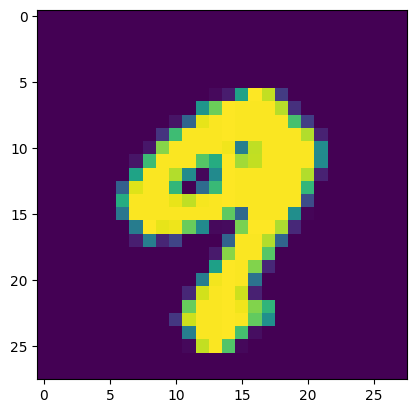

fake


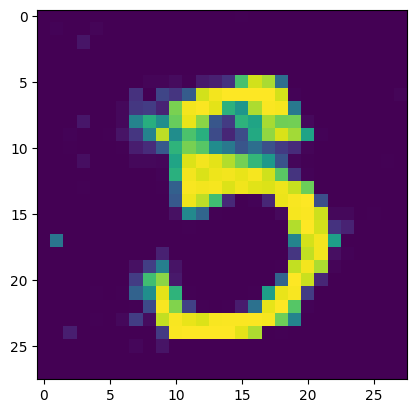

In [29]:

input = imgs.to(device)

for i in input:
  print("real")
  plt.imshow(i[0].reshape(28,28))
  plt.show()
  real_inputs = i[0]
  noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
  noise = noise.to(device)
  fake_inputs = G(noise)
  print("fake")
  plt.imshow(fake_inputs[0][0].cpu().detach().numpy().reshape(28,28))
  plt.show()
  break

In [26]:
real_inputs.shape[0]

28

In [30]:

"""
生成敵対ネットワークの作成に必要なライブラリのインポート
コードは主にPyTorchライブラリを使って開発されています
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt


# GPU利用可否確認
device = torch.device('mps')

# ハイパーパラメタ設定
epochs = 30
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


"""
画像変換とデータローダの作成
ここでは分類ではなく生成のトレーニングを行っているので
train_loaderのみがロードされます。
"""
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


"""
ネットワークの学習手順
識別器と生成器の損失はステップごとに更新される
判別器は本物と偽物を分類することを目的とする
ジェネレータは可能な限りリアルな画像を生成することを目的とする
"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # 識別器の学習
        # 本物の入力は，MNISTデータセットの実際の画像
        # 偽の入力はジェネレータから
        # 本物の入力は1に、偽物は0に分類されるべきである
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()


        # Generatorのトレーニング
        # ジェネレータにとっての目標は 識別者に全てが1であると信じさせること
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')


Epoch 0 Iteration 100: discriminator_loss 0.665 generator_loss 0.921
Epoch 0 Iteration 200: discriminator_loss 0.655 generator_loss 0.773
Epoch 0 Iteration 300: discriminator_loss 0.713 generator_loss 0.696
Epoch 0 Iteration 400: discriminator_loss 0.598 generator_loss 0.869
Epoch 0 Iteration 500: discriminator_loss 0.541 generator_loss 0.866
Epoch 0 Iteration 600: discriminator_loss 0.528 generator_loss 0.871
Epoch 0 Iteration 700: discriminator_loss 0.497 generator_loss 0.972
Epoch 0 Iteration 800: discriminator_loss 0.593 generator_loss 0.867
Epoch 0 Iteration 900: discriminator_loss 0.410 generator_loss 1.197
Epoch 0 Iteration 938: discriminator_loss 0.369 generator_loss 1.289
Epoch 1 Iteration 100: discriminator_loss 0.470 generator_loss 1.186
Epoch 1 Iteration 200: discriminator_loss 0.398 generator_loss 1.391
Epoch 1 Iteration 300: discriminator_loss 0.463 generator_loss 1.290
Epoch 1 Iteration 400: discriminator_loss 0.505 generator_loss 1.067
Epoch 1 Iteration 500: discriminat

real


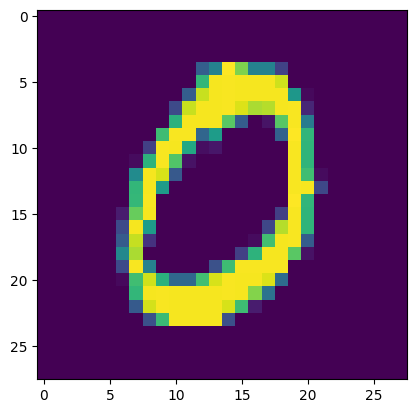

fake


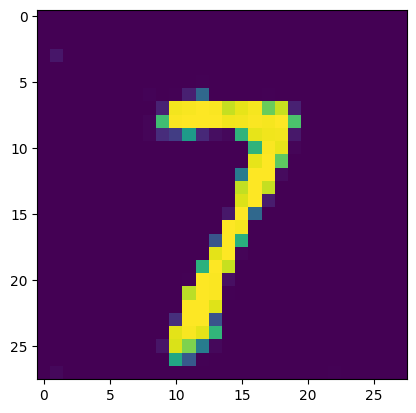

In [40]:

input = imgs.to(device)

for i in input:
  print("real")
  i = i.cpu()
  plt.imshow(i[0].reshape(28,28))
  plt.show()
  real_inputs = i[0]
  noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
  noise = noise.to(device)
  fake_inputs = G(noise)
  print("fake")
  plt.imshow(fake_inputs[0][0].cpu().detach().numpy().reshape(28,28))
  plt.show()
  break

In [32]:
i

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1